In [1]:
# load everything from a file
import os
import h5py
import numpy as np
import pickle
# open file
hdf_path = "/Users/jacobepstein/Documents/work/BirdFlowModels/"
species = "amewoo"
res = 48
hdf_src = os.path.join(hdf_path, f'{species}_2021_{res}km.hdf5')
file = h5py.File(hdf_src, 'r')

# get dynamic mask & nan_mask
masks = np.asarray(file['geom']['dynamic_mask']).T.astype(bool)
nan_mask = ~np.asarray(file['geom']['mask']).flatten().astype(bool)

# get x / y dimensions of the grid
x_dim = int(np.asarray(file['geom']['ncol']))
y_dim = int(np.asarray(file['geom']['nrow']))

total_cells = np.asarray(file['distr']).T.shape[1]

file.close()

In [2]:
from mixture_of_products_model import compute_marginal
from jax.nn import softmax
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
"""
Arguments
week: the week whose marginal we wish to fill into the grid to be plotted
marginal: the marginal from week "week"
masks: the dynamic masks. masks[week] is the one we care about
nan_mask: the mask used to eliminate oceans
x_dim: number of columns of final grid
y_dim: number of rows of the final grid

Returns:
A grid with all the densities of the weekly marginals filled in
"""
def make_grid(week, marginal, masks, nan_mask, x_dim, y_dim):
    medium_grid = np.empty(len(masks[0]))
    medium_grid.fill(0)
    medium_grid[masks[week]] = marginal
    big_grid = np.empty(len(nan_mask))
    big_grid.fill(np.nan)
    big_grid[list(map(lambda b : not b, nan_mask))] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

def plot_weekly_marginal(params, week, masks, nan_mask, x_dim, y_dim, save_dir=None):
    marginal = compute_marginal(params, [week])
    marginal_grid = make_grid(week, marginal, masks, nan_mask, x_dim, y_dim)

    # plot stuff:
    fig, ax = plt.subplots(figsize=(7, 7))
    pos = plt.imshow(marginal_grid, cmap="winter")
    plt.colorbar(pos)
    plt.title(f"MoP Week {week} Marginal")
    ax.set_xlabel(f"ew={params['metadata']['ent_weight']}, dw={params['metadata']['dist_weight']}, dp={params['metadata']['dist_pow']}, n={params['metadata']['num_components']}")
    
    # just visualize the plot if no save path specified
    if save_dir == None:
        plt.show()
    
    # save the plot to the specified directory
    else:
        plt.savefig(os.path.join(save_dir, f'week_{week}.png'))
        plt.close()

def plot_product_k_weekly_marginal(params, k, week, masks, nan_mask, x_dim, y_dim, save_dir=None):
    marginal = softmax(params[f'MixtureOfProductsModel'][f'week_{week}'][k])
    marginal_grid = make_grid(week, marginal, masks, nan_mask, x_dim, y_dim)
    weight_k = softmax(params['MixtureOfProductsModel']['weights'])[k]
    
    # TODO: experiment with custom colormap
    fig, ax = plt.subplots(figsize=(7, 7))
    pos = plt.imshow(marginal_grid, cmap="winter")
    plt.colorbar(pos)
    plt.title(f"MoP Week {week} Marginal (component {k}, weight {weight_k:.5f})") # add weight back!
    ax.set_xlabel(f"ew={params['metadata']['ent_weight']}, dw={params['metadata']['dist_weight']}, dp={params['metadata']['dist_pow']}, n={params['metadata']['num_components']}")
    # just visualize the plot if no save path specified
    if save_dir == None:
        plt.show()
    
    # save the plot to the specified directory
    else:
        plt.savefig(os.path.join(save_dir, f'week_{week}.png'))
        plt.close()

x_dim, y_dim, x_dim * y_dim, total_cells # problem: have to convert (dynamic mask index) -> index in the 2633 grid cells -> indices in the grid given by the 91x66 matrix

# fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
# ax.plot([0,1,2], [10,20,3])
# fig.savefig('path/to/save/image/to.png')   # save the figure to file
# plt.close(fig

(91, 66, 6006, 2633)

In [93]:
from mixture_of_products_gaussian import get_marginals_of_components_for_week_vectorized, get_marginals_of_components_for_week
from jax.nn import softmax
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import jax.numpy as jnp
"""
Arguments
week: the week whose marginal we wish to fill into the grid to be plotted
marginal: the marginal from week "week"
masks: the dynamic masks. masks[week] is the one we care about
nan_mask: the mask used to eliminate oceans
x_dim: number of columns of final grid
y_dim: number of rows of the final grid

Returns:
A grid with all the densities of the weekly marginals filled in
"""
def make_grid(week, marginal, masks, nan_mask, x_dim, y_dim):
    medium_grid = np.empty(len(masks[0]))
    medium_grid.fill(0)
    medium_grid[masks[week]] = marginal
    big_grid = np.empty(len(nan_mask))
    big_grid.fill(np.nan)
    big_grid[list(map(lambda b : not b, nan_mask))] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

def plot_weekly_marginal_gaussian(params, week, masks, nan_mask, x_dim, y_dim, save_dir=None):
    model = params['params']
    metadata = params['metadata']
    weights = jnp.expand_dims(softmax(model.weights), axis=0)
    marginal = model.single_tstep_marginal(get_marginals_of_components_for_week_vectorized(model.centers[week], model.scales[week],
                                                                jnp.array(model.coords[week])), weights)
    marginal_grid = make_grid(week, marginal, masks, nan_mask, x_dim, y_dim)

    # plot stuff:
    fig, ax = plt.subplots(figsize=(7, 7))
    pos = plt.imshow(marginal_grid, cmap="winter")
    plt.colorbar(pos)
    plt.title(f"MoP Week {week} Marginal")
    ax.set_xlabel(f"ew={metadata['ew']}, dw={metadata['dw']}, dp={metadata['dp']}, n={metadata['n']}")
    
    # just visualize the plot if no save path specified
    if save_dir == None:
        plt.show()
    
    # save the plot to the specified directory
    else:
        plt.savefig(os.path.join(save_dir, f'week_{week}.png'))
        plt.close()

def plot_product_k_weekly_marginal_gaussian(params, k, week, masks, nan_mask, x_dim, y_dim, save_dir=None):
    model = params['params']
    metadata = params['metadata']
    weights = jnp.expand_dims(softmax(model.weights), axis=0)
    marginal = get_marginals_of_components_for_week(model.centers[week][k], model.scales[week][k], jnp.array(model.coords[week]))
    marginal_grid = make_grid(week, marginal, masks, nan_mask, x_dim, y_dim)
    weight_k = weights[0][k]
    
    # TODO: experiment with custom colormap
    fig, ax = plt.subplots(figsize=(7, 7))
    pos = plt.imshow(marginal_grid, cmap="winter")
    
    # plot coordinates of the center
    plt.scatter([model.centers[week][k][0]], [model.centers[week][k][1]], color='red')

    plt.colorbar(pos)
    plt.title(f"MoP Week {week} Marginal (component {k}, weight {weight_k:.5f})") # add weight back!
    ax.set_xlabel(f"ew={metadata['ew']}, dw={metadata['dw']}, dp={metadata['dp']}, n={metadata['n']}")
    # just visualize the plot if no save path specified
    if save_dir == None:
        plt.show()
    
    # save the plot to the specified directory
    else:
        plt.savefig(os.path.join(save_dir, f'week_{week}.png'))
        plt.close()



In [94]:
import imageio
import os
"""
Concatentates images in img_dir into a .mp4, saves to save_dir
"""
def video_from_sequence(img_dir, save_dir=None):
    out_video_name = img_dir.split('/')[-1] + ".gif"
    print(f"writing video {out_video_name}")
    out_video_full_path = os.path.join(save_dir, out_video_name)
    
    img_paths = list(map(lambda img : os.path.join(img_dir, img), list(filter(lambda img : not img.startswith('.'), os.listdir(img_dir)))))
    print(img_paths)
    img_paths = sorted(img_paths, key=lambda path: int(path.split('/')[-1].split('_')[1].split('.')[0]))
    images = []
    for filename in img_paths:
        images.append(imageio.imread(filename))
    imageio.mimsave(out_video_full_path, images, loop=0, duration=50)
#     #print(img_paths)
#     cv2_fourcc = cv2.VideoWriter_fourcc(*'mp4v')

#     frame = cv2.imread(img_paths[0])
#     size = list(frame.shape)
#     del size[2]
#     size.reverse()

#     video = cv2.VideoWriter(out_video_full_path, cv2_fourcc, 24, size) #output video name, fourcc, fps, size

#     for img_path in img_paths: 
#         video.write(cv2.imread(img_path))

#     video.release()

"""
Arguments:
params: mixture of products parameters
components: array of component indices to visualize
name: name of parent directory

Description:
Creates visualizations for all weekly marginals for each of the products and the overall MOP, stores in a solidly 
organized directory
"""
def load_and_store_marginal_visualizations(params, components, name, masks, nan_mask, x_dim, y_dim, gaussian_parameterization=True):
    # create parent directory
    try:
        os.mkdir(os.path.join('visualizations', name))
    except:
        print("directory probably exists already, delete and try again")
        return
    timelapse_dir = os.path.join('visualizations', name, 'timelapses')
    os.mkdir(timelapse_dir)
    
    for k in components:
        # create directory
        save_dir = os.path.join('visualizations', name, f'Component{k}')
        os.mkdir(save_dir)
        for t in range(53):
            if gaussian_parameterization:
                plot_product_k_weekly_marginal_gaussian(params, k, t, masks, nan_mask, x_dim, y_dim, save_dir=save_dir)
            else:
                plot_product_k_weekly_marginal(params, k, t, masks, nan_mask, x_dim, y_dim, save_dir=save_dir)
        video_from_sequence(save_dir, timelapse_dir)
    
    # compute and store overall marginals
    save_dir = os.path.join('visualizations', name, "overall")
    os.mkdir(save_dir)
    for t in range(53):
        if gaussian_parameterization:
            plot_weekly_marginal_gaussian(params, t, masks, nan_mask, x_dim, y_dim, save_dir=save_dir)
        else:
            plot_weekly_marginal(params, t, masks, nan_mask, x_dim, y_dim, save_dir=save_dir)
    video_from_sequence(save_dir, timelapse_dir)
    return



In [133]:
from mixture_of_products_gaussian import MixtureOfProducts
import pickle
fname = "/Users/jacobepstein/Downloads/params_save_step20_n150.pkl"
with open(fname, 'rb') as f:
    mop_params = pickle.load(f)
mop_params['metadata'] = {'ew': 1e-4, 'dw': 1e-2, 'dp': 0.4, 'n': 150}
load_and_store_marginal_visualizations(mop_params, [54, 34, 24, 48, 116], "gaussian_params_n150_step20", masks, nan_mask, x_dim, y_dim)

writing video Component54.gif
['visualizations/gaussian_params_n150_step20/Component54/week_48.png', 'visualizations/gaussian_params_n150_step20/Component54/week_49.png', 'visualizations/gaussian_params_n150_step20/Component54/week_6.png', 'visualizations/gaussian_params_n150_step20/Component54/week_17.png', 'visualizations/gaussian_params_n150_step20/Component54/week_16.png', 'visualizations/gaussian_params_n150_step20/Component54/week_7.png', 'visualizations/gaussian_params_n150_step20/Component54/week_5.png', 'visualizations/gaussian_params_n150_step20/Component54/week_14.png', 'visualizations/gaussian_params_n150_step20/Component54/week_28.png', 'visualizations/gaussian_params_n150_step20/Component54/week_29.png', 'visualizations/gaussian_params_n150_step20/Component54/week_15.png', 'visualizations/gaussian_params_n150_step20/Component54/week_4.png', 'visualizations/gaussian_params_n150_step20/Component54/week_0.png', 'visualizations/gaussian_params_n150_step20/Component54/week_39.

/var/folders/cy/ytbbt0v93sx8p6kz3mn8qr9m0000gn/T/ipykernel_46302/1666602774.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


writing video Component34.gif
['visualizations/gaussian_params_n150_step20/Component34/week_48.png', 'visualizations/gaussian_params_n150_step20/Component34/week_49.png', 'visualizations/gaussian_params_n150_step20/Component34/week_6.png', 'visualizations/gaussian_params_n150_step20/Component34/week_17.png', 'visualizations/gaussian_params_n150_step20/Component34/week_16.png', 'visualizations/gaussian_params_n150_step20/Component34/week_7.png', 'visualizations/gaussian_params_n150_step20/Component34/week_5.png', 'visualizations/gaussian_params_n150_step20/Component34/week_14.png', 'visualizations/gaussian_params_n150_step20/Component34/week_28.png', 'visualizations/gaussian_params_n150_step20/Component34/week_29.png', 'visualizations/gaussian_params_n150_step20/Component34/week_15.png', 'visualizations/gaussian_params_n150_step20/Component34/week_4.png', 'visualizations/gaussian_params_n150_step20/Component34/week_0.png', 'visualizations/gaussian_params_n150_step20/Component34/week_39.

writing video Component116.gif
['visualizations/gaussian_params_n150_step20/Component116/week_48.png', 'visualizations/gaussian_params_n150_step20/Component116/week_49.png', 'visualizations/gaussian_params_n150_step20/Component116/week_6.png', 'visualizations/gaussian_params_n150_step20/Component116/week_17.png', 'visualizations/gaussian_params_n150_step20/Component116/week_16.png', 'visualizations/gaussian_params_n150_step20/Component116/week_7.png', 'visualizations/gaussian_params_n150_step20/Component116/week_5.png', 'visualizations/gaussian_params_n150_step20/Component116/week_14.png', 'visualizations/gaussian_params_n150_step20/Component116/week_28.png', 'visualizations/gaussian_params_n150_step20/Component116/week_29.png', 'visualizations/gaussian_params_n150_step20/Component116/week_15.png', 'visualizations/gaussian_params_n150_step20/Component116/week_4.png', 'visualizations/gaussian_params_n150_step20/Component116/week_0.png', 'visualizations/gaussian_params_n150_step20/Compon

In [95]:
import math

def count_collapsed_marginals(model, n, T):
    collapsed_count = 0
    for t in range(T):
        print(f"done with week {t}")
        for k in range(n):
            marginal = get_marginals_of_components_for_week(model.centers[t][k], model.scales[t][k], jnp.array(model.coords[t]))
            if jnp.allclose(marginal, marginal[0] * jnp.ones_like(marginal)):
                collapsed_count += 1
    return collapsed_count


In [96]:
fname = "/Users/jacobepstein/Downloads/params_save_step18_n150.pkl"
with open(fname, 'rb') as f:
    model_18 = pickle.load(f)['params']
fname = "/Users/jacobepstein/Downloads/params_save_step19_n150.pkl"
with open(fname, 'rb') as f:
    model_19 = pickle.load(f)['params']
fname = "/Users/jacobepstein/Downloads/params_save_step20_n150.pkl"
with open(fname, 'rb') as f:
    model_20 = pickle.load(f)['params']

top5_19 = sorted(enumerate(softmax(model_19.weights)), key=lambda tup: tup[1])[-5:]
top5_20 = sorted(enumerate(softmax(model_20.weights)), key=lambda tup: tup[1])[-5:]
top5_19, top5_20

([(54, Array(0.0102322, dtype=float32)),
  (34, Array(0.01052019, dtype=float32)),
  (24, Array(0.01052107, dtype=float32)),
  (48, Array(0.01069284, dtype=float32)),
  (116, Array(0.01141858, dtype=float32))],
 [(54, Array(0.01062672, dtype=float32)),
  (24, Array(0.01082827, dtype=float32)),
  (34, Array(0.01088546, dtype=float32)),
  (48, Array(0.01124605, dtype=float32)),
  (116, Array(0.01195974, dtype=float32))])

In [159]:
collapsed_18 = count_collapsed_marginals(model_18, 150, 53)
collapsed_19 = count_collapsed_marginals(model_19, 150, 53)
collapsed_20 = count_collapsed_marginals(model_20, 150, 53)

done with week 0
done with week 1
done with week 2
done with week 3
done with week 4
done with week 5
done with week 6
done with week 7
done with week 8
done with week 9
done with week 10
done with week 11
done with week 12
done with week 13
done with week 14
done with week 15
done with week 16
done with week 17
done with week 18
done with week 19
done with week 20
done with week 21
done with week 22
done with week 23
done with week 24
done with week 25
done with week 26
done with week 27
done with week 28
done with week 29
done with week 30
done with week 31
done with week 32
done with week 33
done with week 34
done with week 35
done with week 36
done with week 37
done with week 38
done with week 39
done with week 40
done with week 41
done with week 42
done with week 43
done with week 44
done with week 45
done with week 46
done with week 47
done with week 48
done with week 49
done with week 50
done with week 51
done with week 52
done with week 0
done with week 1
done with week 2
done 

[[  0  30   0]
 [  0  30   1]
 [  0  37   0]
 ...
 [ 52  75   1]
 [ 52 107   0]
 [ 52 107   1]]
[39.249466 14.091846] 0.05195164
[39.241764 14.136358] -0.049722098
[nan nan] nan


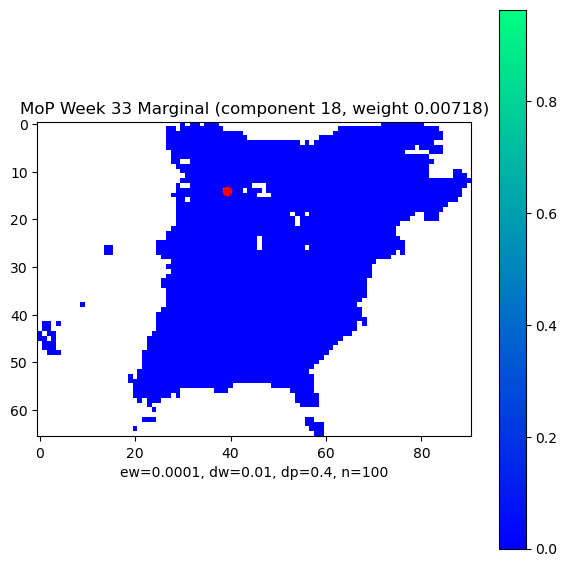

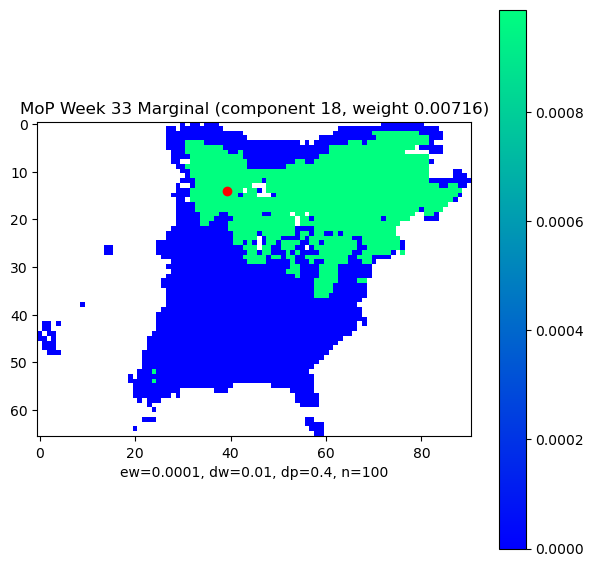

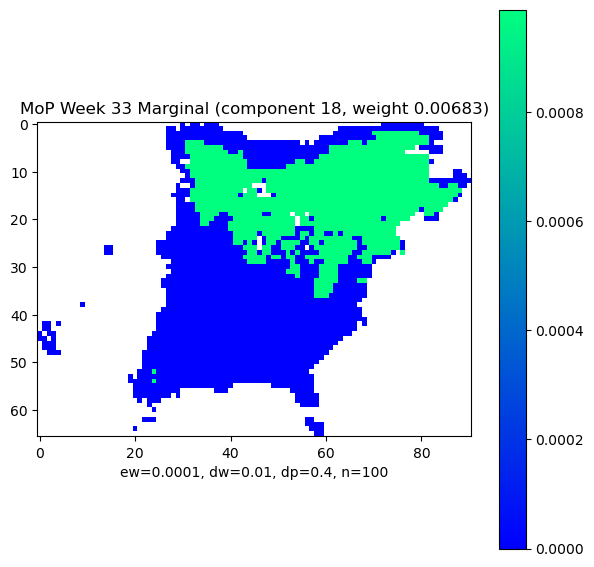

In [97]:
print(jnp.argwhere(jnp.isnan(model_20.centers)))
t, k = jnp.argwhere(jnp.isnan(model_20.centers))[1000][:2]
print(model_18.centers[t][k], model_18.scales[t][k])
print(model_19.centers[t][k], model_19.scales[t][k])
print(model_20.centers[t][k], model_20.scales[t][k])

plot_product_k_weekly_marginal_gaussian({'params': model_18, 'metadata': {'n': 100, 'ew': 1e-4, 'dw': 1e-2, 'dp': 0.4, 'T': 53}}, k, t, masks, nan_mask, x_dim, y_dim, save_dir=None)
plot_product_k_weekly_marginal_gaussian({'params': model_19, 'metadata': {'n': 100, 'ew': 1e-4, 'dw': 1e-2, 'dp': 0.4, 'T': 53}}, k, t, masks, nan_mask, x_dim, y_dim, save_dir=None)
plot_product_k_weekly_marginal_gaussian({'params': model_20, 'metadata': {'n': 100, 'ew': 1e-4, 'dw': 1e-2, 'dp': 0.4, 'T': 53}}, k, t, masks, nan_mask, x_dim, y_dim, save_dir=None)






writing video Component0.gif
['visualizations/test/Component0/week_0.png', 'visualizations/test/Component0/week_1.png', 'visualizations/test/Component0/week_10.png', 'visualizations/test/Component0/week_11.png', 'visualizations/test/Component0/week_12.png', 'visualizations/test/Component0/week_13.png', 'visualizations/test/Component0/week_14.png', 'visualizations/test/Component0/week_15.png', 'visualizations/test/Component0/week_16.png', 'visualizations/test/Component0/week_17.png', 'visualizations/test/Component0/week_18.png', 'visualizations/test/Component0/week_19.png', 'visualizations/test/Component0/week_2.png', 'visualizations/test/Component0/week_20.png', 'visualizations/test/Component0/week_21.png', 'visualizations/test/Component0/week_22.png', 'visualizations/test/Component0/week_23.png', 'visualizations/test/Component0/week_24.png', 'visualizations/test/Component0/week_25.png', 'visualizations/test/Component0/week_26.png', 'visualizations/test/Component0/week_27.png', 'visual

/tmp/ipykernel_422178/2618734052.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


writing video Component116.gif
['visualizations/test/Component116/week_0.png', 'visualizations/test/Component116/week_1.png', 'visualizations/test/Component116/week_10.png', 'visualizations/test/Component116/week_11.png', 'visualizations/test/Component116/week_12.png', 'visualizations/test/Component116/week_13.png', 'visualizations/test/Component116/week_14.png', 'visualizations/test/Component116/week_15.png', 'visualizations/test/Component116/week_16.png', 'visualizations/test/Component116/week_17.png', 'visualizations/test/Component116/week_18.png', 'visualizations/test/Component116/week_19.png', 'visualizations/test/Component116/week_2.png', 'visualizations/test/Component116/week_20.png', 'visualizations/test/Component116/week_21.png', 'visualizations/test/Component116/week_22.png', 'visualizations/test/Component116/week_23.png', 'visualizations/test/Component116/week_24.png', 'visualizations/test/Component116/week_25.png', 'visualizations/test/Component116/week_26.png', 'visualizat

KeyboardInterrupt: 

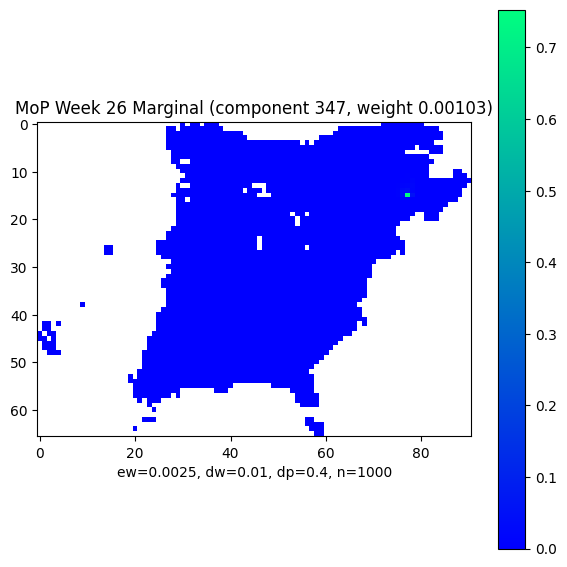

In [5]:
import jax.numpy as jnp
fname = "/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/mixture_of_products/experiments/test/mop_params_amewoo_48km_obs1.0_ent0.0025_dist0.01_pow0.4_n1000_key42.pkl"
with open(fname, 'rb') as f:
    mop_params = pickle.load(f)
load_and_store_marginal_visualizations(mop_params, [0, 116, 237, 347, 487, 594, 698, 826, 949], "test", masks, nan_mask, x_dim, y_dim)


In [16]:
from jax.nn import softmax
fname = "/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/mixture_of_products/experiments/varying_entropy_weight_debugged/mop_params_amewoo_48km_obs1.0_ent0.0001_dist0.01_pow0.4_n1000_key42_scale20.0_unboxed.pkl"
with open(fname, 'rb') as f:
    mop_params = pickle.load(f)
weights = softmax(mop_params['MixtureOfProductsModel']['weights'])
#print(weights)
collapsed_indices = list(filter(lambda tup: tup[1] < 1e-5, enumerate(weights)))
#print(collapsed_indices)
print(len(collapsed_indices))
print(len(collapsed_indices)/1000)

uncollapsed_indices = list(filter(lambda tup: tup[1] > 1e-5, enumerate(weights)))

print(len(uncollapsed_indices))
print(list(map(lambda tup: tup[0], uncollapsed_indices[::20])))
print(list(map(lambda tup: tup[0], collapsed_indices[::100])))

829
0.829
171
[0, 116, 237, 347, 487, 594, 698, 826, 949]
[1, 122, 243, 362, 478, 605, 724, 844, 963]


In [5]:
# load and store visualizations for parameters with all the different entropy weights
ews = [1.0, 10.0]

for ew in ews:
    ew_f=f"/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/mixture_of_products/experiments/varying_entropy_weight_debugged/mop_params_amewoo_48km_obs1.0_ent{ew}_dist0.01_pow0.4_n1000_key42_dim5_scale3.0.pkl"
    with open(ew_f, 'rb') as f:
        mop_params = pickle.load(f)
    load_and_store_marginal_visualizations(mop_params, [0, 100, 200, 300, 400, 500, 600, 700, 800, 900], f"fine_tuned_ew{ew}_dim5_scale3", masks, nan_mask, x_dim, y_dim)
    
    

writing video Component0.gif
['visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_0.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_1.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_10.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_11.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_12.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_13.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_14.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_15.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_16.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_17.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_18.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_19.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_2.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_20

/tmp/ipykernel_113229/2618734052.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


writing video Component100.gif
['visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_0.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_1.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_10.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_11.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_12.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_13.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_14.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_15.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_16.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_17.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_18.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_19.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_2.png', 'visualizations/fine_tuned_ew1.0_di

KeyboardInterrupt: 